In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
import tensorflow as tf

In [6]:
df = pd.read_excel('ENB2012_data.xlsx', index_col=None)  

In [15]:
df = df.sample(frac=0.5).reset_index(drop=True) # sample from dataset

# Notice there are TWO outputs to predict - Y1 & Y2

In [40]:
df

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.90,563.5,318.5,122.50,7.0,5,0.25,2,31.66,37.72
1,0.64,784.0,343.0,220.50,3.5,3,0.00,0,10.54,16.80
2,0.79,637.0,343.0,147.00,7.0,2,0.40,4,42.77,38.33
3,0.82,612.5,318.5,147.00,7.0,2,0.10,3,22.93,28.68
4,0.98,514.5,294.0,110.25,7.0,5,0.25,4,28.62,30.12
...,...,...,...,...,...,...,...,...,...,...
187,0.82,612.5,318.5,147.00,7.0,3,0.25,2,25.98,26.96
188,0.79,637.0,343.0,147.00,7.0,5,0.25,4,40.12,37.26
189,0.74,686.0,245.0,220.50,3.5,3,0.25,4,12.30,15.24
190,0.86,588.0,294.0,147.00,7.0,4,0.25,3,29.43,28.38


In [41]:
train, test = train_test_split(df, test_size=0.2)

In [32]:
# Extract Y variables

In [25]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2

In [42]:
train_y = format_output(train)
test_y = format_output(test)

In [48]:
# Exploratory analysis

In [43]:
train_stats = train.describe()

In [44]:
train_stats

,X1,X2,X3,X4,X5,X6,X7,X8
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.763464,672.388889,323.143791,174.622549,5.352941,3.575163,0.234967,2.620915
std,0.107858,90.930501,43.876609,44.735003,1.752707,1.151045,0.131049,1.597723
min,0.620000,514.500000,245.000000,110.250000,3.500000,2.000000,0.000000,0.000000
25%,0.660000,612.500000,294.000000,147.000000,3.500000,3.000000,0.100000,1.000000
50%,0.760000,661.500000,318.500000,147.000000,7.000000,4.000000,0.250000,2.000000
75%,0.820000,759.500000,343.000000,220.500000,7.000000,5.000000,0.400000,4.000000
max,0.980000,808.500000,416.500000,220.500000,7.000000,5.000000,0.400000,5.000000


In [45]:
train_stats = train_stats.transpose()

In [46]:
train_stats

,count,mean,std,min,25%,50%,75%,max
X1,153.0,0.763464,0.107858,0.62,0.66,0.76,0.82,0.98
X2,153.0,672.388889,90.930501,514.50,612.50,661.50,759.50,808.50
X3,153.0,323.143791,43.876609,245.00,294.00,318.50,343.00,416.50
X4,153.0,174.622549,44.735003,110.25,147.00,147.00,220.50,220.50
X5,153.0,5.352941,1.752707,3.50,3.50,7.00,7.00,7.00
X6,153.0,3.575163,1.151045,2.00,3.00,4.00,5.00,5.00
X7,153.0,0.234967,0.131049,0.00,0.10,0.25,0.40,0.40
X8,153.0,2.620915,1.597723,0.00,1.00,2.00,4.00,5.00


In [ ]:
# Normalize training and test data

In [49]:
def norm(x):
    return (x-train_stats['mean']) / train_stats['std']

In [53]:
train_x = train
test_x = test

In [54]:
norm_train_x = norm(train_x)
norm_test_x = norm(test_x)

# Creating Multi-Output Model

In [59]:
input_layer = Input(shape=(len(train_x.columns)),)
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

In [62]:
# Y1 output will be fed directly from second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)

In [61]:
# Y2 output will be fed after the output of a third dense layer
third_dense = Dense(units='64', activation='relu')(second_dense)
y2_output = y1_output = Dense(units='1', name='y2_output')(third_dense)

In [63]:
# Define model with input layer and LIST of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output]) 

In [64]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

In [79]:
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics = {'y1_output': tf.keras.metrics.RootMeanSquaredError(), 
                         'y2_output': tf.keras.metrics.RootMeanSquaredError()
                        }
             )

In [80]:
model._layers = [
    layer for layer in model._layers if isinstance(layer, Layer)
]

# Visualise model

In [72]:
from tensorflow.python.keras.utils.vis_utils import plot_model

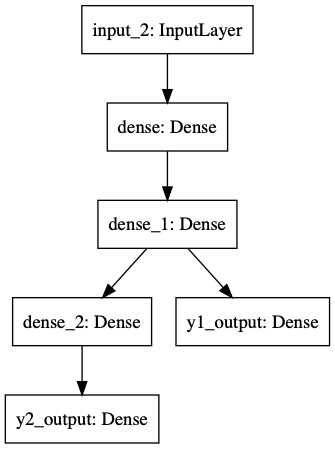

In [75]:
plot_model(model)

# Run model

In [81]:
history = model.fit(norm_train_x, train_y,
                    epochs=20, batch_size=10, validation_data=(norm_test_x, test_y))

Epoch 1/20
16/16 [==============================] - 1s 17ms/step - loss: 1167.8350 - y1_output_loss: 558.4499 - y2_output_loss: 609.3851 - y1_output_root_mean_squared_error: 23.5781 - y2_output_root_mean_squared_error: 24.6025 - val_loss: 227.0684 - val_y1_output_loss: 66.0483 - val_y2_output_loss: 161.0200 - val_y1_output_root_mean_squared_error: 8.1270 - val_y2_output_root_mean_squared_error: 12.6894
Epoch 2/20
16/16 [==============================] - 0s 4ms/step - loss: 75.2038 - y1_output_loss: 35.9301 - y2_output_loss: 39.2738 - y1_output_root_mean_squared_error: 5.9764 - y2_output_root_mean_squared_error: 6.2539 - val_loss: 62.2681 - val_y1_output_loss: 28.1854 - val_y2_output_loss: 34.0828 - val_y1_output_root_mean_squared_error: 5.3090 - val_y2_output_root_mean_squared_error: 5.8380
Epoch 3/20
16/16 [==============================] - 0s 5ms/step - loss: 58.8758 - y1_output_loss: 25.0725 - y2_output_loss: 33.8033 - y1_output_root_mean_squared_error: 4.9625 - y2_output_root_mean_

In [82]:
model.evaluate(x=norm_test_x, y=test_y)

2/2 [==============================] - 0s 2ms/step - loss: 26.9187 - y1_output_loss: 10.5268 - y2_output_loss: 16.3919 - y1_output_root_mean_squared_error: 3.2445 - y2_output_root_mean_squared_error: 4.0487


[26.918745040893555,
 10.52682113647461,
 16.391923904418945,
 3.244506359100342,
 4.048694133758545]

In [83]:
y_pred = model.predict(norm_test_x)

In [88]:
y1_pred, y2_pred = y_pred # PREDICTIONS for BOTH Y1 and Y2